_____________
Practice and notes from online course: 
[Python for Financial Analysis and Algorithmic Trading](https://www.udemy.com/python-for-finance-and-trading-algorithms/learn/v4/content) <br>
Comments are just my understanding, mostly

It is said that an ASR > 1 is good; ASR > 2 is very good

# Portfolio: #
#### Allocations; Inverstment / Postion values; Returns and Volatility; ####
#### Sharpe Ratio (with daily, weekly, monthly data);
#### Log return ###
#### Portfolio optimization (and Efficient Frontier Line), (using Monte Carlo method, or scipy.optimize)
__________________________
** 3 major trading funds: ETF (Exchange Traded Funds), Mutual Funds, Hedge Funds. (Expense ratios: low to high) ** <br>
** High Frequency Trading (HTF) firm: latency arbitrage ** <br>
** Short selling **

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quandl
import pandas as pd
import pandas_datareader.data as web
#import pandas_datareader.data as web
%matplotlib inline

In [2]:
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('2017-01-01')

In [6]:
aapl = quandl.get('WIKI/AAPL.11', start_date=start, end_date=end) # APPL.11 for 11th column: 'Adj.Close'
cisco = quandl.get('WIKI/CSCO.11', start_date=start, end_date=end)
ibm = quandl.get('WIKI/IBM.11', start_date=start, end_date=end)
amzn = quandl.get('WIKI/AMZN.11', start_date=start, end_date=end)
# amzn = pd.read_csv('../../ML_finance_Udemy/Python-for-Finance-Repo-master/09-Python-Finance-Fundamentals/AMZN_CLOSE', 
#                   index_col='Date', parse_dates=True)
# loaded from file once when I re-import the data and exceeds the free access limit    

In [7]:
aapl.shape

(1258, 1)

In [8]:
cisco.head(3)

,Adj. Close
Date,
2012-01-03,15.617341
2012-01-04,15.919125
2012-01-05,15.860445


In [9]:
for df in (aapl, cisco, ibm, amzn):
    df['Norm Return'] = df['Adj. Close']/df.iloc[0]['Adj. Close']

In [10]:
aapl.head(3)

,Adj. Close,Norm Return
Date,,
2012-01-03,52.848787,1.000000
2012-01-04,53.132802,1.005374
2012-01-05,53.722681,1.016536


# Allocations #
#### Assuming initial stock allocation: 0.3, 0.2, 0.4, 0.1 ####

In [11]:
for df, allo in zip((aapl, cisco, ibm, amzn), [0.3, 0.2, 0.4, 0.1]):
    df['Allocation'] = df['Norm Return']*allo

In [12]:
last = aapl.shape[0] -1
print(last)
print(aapl.iloc[last]['Allocation'], cisco.iloc[last]['Allocation'], ibm.iloc[last]['Allocation'], amzn.iloc[last]['Allocation'])

1257
0.6493400956921899 0.37363621532336966 0.40560061803185277 0.4188515891191421


** Just to find out the portfolio ratio will be quite different by the end of the data **

# Investment / Position values #
### assume the portfolio started with 1000000 ###

In [13]:
for df in (aapl, cisco, ibm, amzn):
    df['Position value'] = df['Allocation']*1000000

In [14]:
portfolio_val = pd.concat([aapl['Position value'], cisco['Position value'], ibm['Position value'], amzn['Position value']],
                         axis=1)
portfolio_val.columns = ['Aapl Pos', 'Cisco Pos', 'Ibm Pos', 'Amzn Pos']
portfolio_val['Total'] = portfolio_val.sum(axis=1)
portfolio_val.head(3)

,Aapl Pos,Cisco Pos,Ibm Pos,Amzn Pos,Total
Date,,,,,
2012-01-03,300000.000000,200000.000000,400000.000000,100000.000000,1.000000e+06
2012-01-04,301612.236461,203864.734300,398368.223296,99150.980283,1.002996e+06
2012-01-05,304960.727573,203113.258186,396478.797638,99206.836843,1.003760e+06


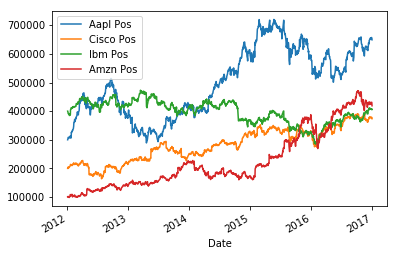

In [15]:
portfolio_val.drop('Total', axis=1).plot();

# Portfolio Statistics #
### Daily Returns ###

In [16]:
portfolio_val['Daily Return'] = portfolio_val['Total'].pct_change(1)

### Cumulative Return ###

In [17]:
cum_ret = 100*(portfolio_val['Total'][-1]/portfolio_val['Total'][0] - 1)
print('The cumulative return is {:6.3f}%'.format(cum_ret))

The cumulative return is 84.743%


### Average Daily Return ###

In [18]:
portfolio_val['Daily Return'].mean()

0.0005442330716215244

### Std Daily Deviation ### 

In [19]:
portfolio_val['Daily Return'].std()

0.010568287769161725

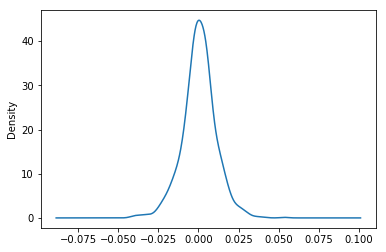

In [20]:
portfolio_val['Daily Return'].plot(kind='kde');

# Sharpe ratio #
* SR = (Rp - Rf)/Dlta_p (in other words: SR=mean return/Std.Deviaiton
* Annualized Sharp ratio: ASR = K*SR, where K=sqrt(252), sqrt(52), sqrt(12) for daily, weekly, monthly data sampling rate

Why? <br> Central limit theroem: yearly_std = daily_std/sqrt(252), and if assum: yearly_return = daily_return ** 252 
<br>
==> yearly_return/yearly_std = daily_return/daily_std * sqrt(252

It is said that ASR > 1 is good to investers; ASR > 2 is very good

In [21]:
SR = portfolio_val['Daily Return'].mean()/portfolio_val['Daily Return'].std()
print(SR)

0.05149680662648089


In [22]:
ASR = np.sqrt(252)*SR
ASR

0.817486461885909

# Log Return #
#### Advantage of log return:####
* log(a1/a0) + log(a2/a1) + ... + log(a_n/a_n-1) = log(a_n/a0) ==> easy to calculate total log return and daily log return
* log(a1/a0) = log(1 + delta/a0) ~ delta/a0 ==> assume delta << a0, log_return ~ pct_change

In [23]:
clmns = ['Aapl Pos', 'Cisco Pos', 'Ibm Pos','Amzn Pos']
log_ret = np.log(portfolio_val[clmns]/portfolio_val[clmns].shift(1))

In [24]:
log_ret.head(3)

,Aapl Pos,Cisco Pos,Ibm Pos,Amzn Pos
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563


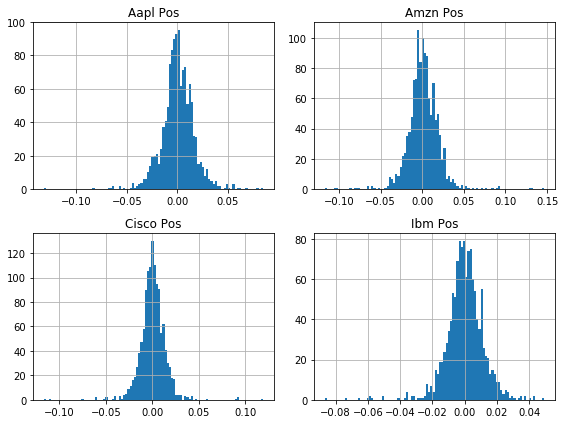

In [25]:
log_ret.hist(bins=100, figsize=(8,6))
plt.tight_layout()

In [26]:
log_ret.mean()*252

Aapl Pos     0.154803
Cisco Pos    0.125291
Ibm Pos      0.002788
Amzn Pos     0.287153
dtype: float64

In [27]:
# pairwise covariance of columns
log_ret.cov()

,Aapl Pos,Cisco Pos,Ibm Pos,Amzn Pos
Aapl Pos,0.000271,0.000071,0.000057,0.000075
Cisco Pos,0.000071,0.000204,0.000072,0.000079
Ibm Pos,0.000057,0.000072,0.000140,0.000059
Amzn Pos,0.000075,0.000079,0.000059,0.000375


# Portfolio optimization #
Modern Portfolio Theory (MTP): maximize Sharpe Ratio

## Monte Carlo simulation for optimization search ##
Using the average return over all the data !!

In [37]:
num_loops = 15000
clmns = len(log_ret.columns)

all_weights = np.zeros((num_loops, clmns))  # keep a record for find the optimized weghts
ret_arr = np.zeros((num_loops,))  # yearly return for all possible portfolio weights. keep an array for plotting
volat_arr = np.zeros((num_loops,))  # yearly volatility for all possible portfolio weights. keep an array for plotting
sharpe = np.zeros((num_loops,))  # annually sharpe ratio for all possible portfolio weights. keep an array for plotting

np.random.seed(101)
for i in range(num_loops):
    weights = np.array(np.random.random(clmns))   # shape: (clmns,)
    weights = weights/sum(weights)
    all_weights[i, :] = weights
    ret_arr[i] = np.sum(log_ret.mean()*weights*252)  # yearly return = daily return * days, because log-return !!! 
    volat_arr[i]= np.sqrt(np.dot(np.dot(weights.T, log_ret.cov()*252), weights))  # yearly volatility, at loop i
    # it is a simple way of coding for speed, but it took me a while to confirm the math, see comments below.
    sharpe[i] = ret_arr[i]/volat_arr[i]


### the math of this yearly volatility calculation ###
- using covariance matrix for portfolio volatility: <br>
Assume the dataframe A has data $ a \in \mathbb{R}^{N\times p}$, with $\bar{a}_j$ represents the mean of jth column. Its covariance is: <br>
$$ (A.cov)_{ij} = \frac{1}{N} \sum_{k=1}^{N}(a_{ki}-\bar{a_i})(a_{kj}-\bar{a_j})$$ <br>
The calculation used in the code is (where w_i is the weight for ith column): <br>
$$ \sum_{i=1}^{p}\sum_{j=1}^{p}w_i(A.cov)_{ij}w_j = \frac{1}{N}\sum_{k=1}^{N}\sum_{ij}^{p}w_i(a_{ki}-\bar{a_i})(a_{kj}-\bar{a_j})w_j = \frac{1}{N}\sum_{k=1}^{N}(\sum_{i=1}^{p}w_i a_{ki} - \sum_{i=1}^{p}w_i \bar{a_i})(\sum_{j=1}^{p}w_j a_{kj} - \sum_{j=1}^{p}w_j \bar{a_j}) = \frac{1}{N}\sum_{k=1}^{N}(A_k - \bar{A_k})^2 $$
where $ A_k = \sum_{i=1}^{p}w_i a_{ki}$  , and $ \bar{A_k} = \sum_{i=1}^{p}w_i \bar{a_i} $ are the weight averaged _k_ th row of A data <br>
** Becuase $w_i$ is only column dependent, not row dependent, therefore the above equiations are always valid ** 

- About converting daily covariance to yearly covariance. <br>
According to central limit theorem, with sample size of N, the sample mean std is orignal std divided by sqrt(N), therefore the yearly mean covariance should be the daily covariance divided by N where N is 252. <br>
- But I do have a problem with covariance calculation: <br>
Because the stock "Close" data are obviously NOT stationary, where the mean values are different from year to year, therefore the actual sampling of each year is NOT "randomly" from all the data, therefore does the central limit theorem still valid? If a stock has not volatility but only monotonically increase, with the algorithm given here, the increase will create covariance.

In [38]:
sharpe.max()

1.0303260551271316

In [40]:
all_weights[sharpe.argmax()]

array([0.26188068, 0.20759516, 0.00110226, 0.5294219 ])

## Plotting the data ##

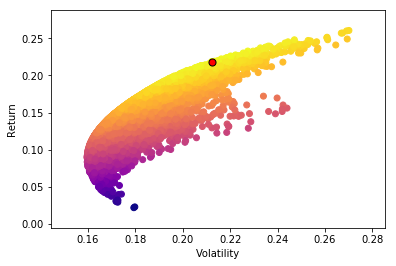

In [42]:
return_optim = ret_arr[sharpe.argmax()]
volat_optim = volat_arr[sharpe.argmax()]
plt.scatter(volat_arr, ret_arr, c=sharpe, cmap='plasma')
plt.scatter(volat_optim, return_optim, s=50, c='red', edgecolors='k')  # the red dot at optim
plt.xlabel('Volatility')
plt.ylabel('Return')

## Portfolio optimization using scipy.optimize ##

In [47]:
from scipy.optimize import minimize

In [43]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array of return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [44]:
def neg_sharpe(weights):  # because scipy minimizing target
    return  get_ret_vol_sr(weights)[2] * (-1)

In [45]:
# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [46]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

In [48]:
# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

In [49]:
# Initial Guess (equal distribution)
init_guess = [0.25,0.25,0.25,0.25]

In [50]:
# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [51]:
opt_results

     fun: -1.0307168703352194
     jac: array([ 5.64306974e-05,  4.18573618e-05,  3.39921713e-01, -4.45097685e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.26628976, 0.20418983, 0.        , 0.5295204 ])

In [52]:
opt_results.x   # the inputs of the optimized function, neg_sharpe

array([0.26628976, 0.20418983, 0.        , 0.5295204 ])

In [53]:
# the yearly return, volatility, sharpe ratio, when optimized
get_ret_vol_sr(opt_results.x)

array([0.21885915, 0.21233683, 1.03071687])

# Frontier Line for Portfolio Optimization # 
To calculate a line, instead of 2D dots, in the return vs volatility graph

In [54]:
frontier_y = np.linspace(0,0.3,100) # previous plot shows data of y from 0 to somewhere along 0.3

In [55]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

In [56]:
frontier_volatility = []

for possible_y in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_y})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

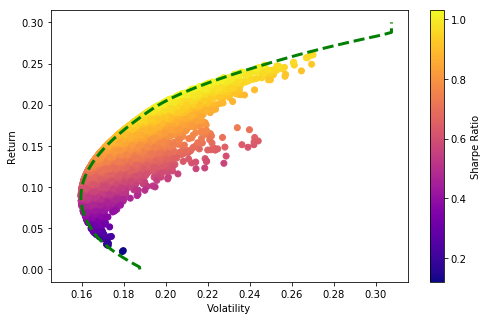

In [60]:
plt.figure(figsize=(8,5))
plt.scatter(volat_arr,ret_arr,c=sharpe,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)